In [1]:
import networkx as nx
from matplotlib import pyplot as plt
import random
import numpy as np
import scipy.stats
import seaborn as sns

In [2]:
def initialize(N, cls, min_power, alphas, p=0, k=0):
    if cls == 'random':
        G =  nx.erdos_renyi_graph(N, p)
    elif cls == 'watts':
        G = nx.connected_watts_strogatz_graph(N, k=k, p=p)
    elif cls == 'ring':
        G = nx.watts_strogatz_graph(N, k=k, p=0)
    elif cls == 'barabasi':
        G = nx.powerlaw_cluster_graph(N, m=k, p=p)
    else:
        G = nx.Graph()
        for i in range(N):
            G.add_node(i)
        for i in range(N):
            for j in range(N):
                if i != j:
                    G.add_edge(i, j)
    for alpha, node in enumerate(G.nodes()):
        G.node[node]['power'] = min_power
        G.node[node]['alpha'] = alphas[alpha]*0.01
        G.node[node]['surplus'] = 0
        G.node[node]['alloc'] = 0
    return G




def generate_power(G, P, max_power):
    for i, node in enumerate(G.nodes()):
        if G.node[node]['power'] == 0:
            continue
        G.node[node]['power'] += G.node[node]['alpha']*P
#         if G.node[node]['power'] > max_power:
#             G.node[node]['power'] = max_power
#         if G.node[node]['power'] < 0:
#             G.node[node]['power'] = 0
        #G.node[node]['power'] += random.uniform(0, a)
    return G





def use_power(G, exp_alpha):
    for node in G.nodes():
        if G.node[node]['power'] == 0:
            continue
        G.node[node]['power'] -= exp_alpha/np.pi
        
        if G.node[node]['power'] > max_power:
            G.node[node]['power'] = max_power
        if G.node[node]['power'] < 0:
            G.node[node]['power'] = 0
    return G


def send_power(G, min_power):
    for node in G.nodes():
        if G.node[node]['power'] > min_power:
            G.node[node]['surplus'] = G.node[node]['power'] - min_power
        else:
            G.node[node]['surplus'] = 0
        
        neighbors = list(G.neighbors(node))
        for neighbor in neighbors:
            G.node[neighbor]['alloc'] += G.node[node]['surplus']/len(neighbors)
    return G

def update_power(G, max_power):
    for node in G.nodes():
        if G.node[node]['power'] == 0:
            continue
        G.node[node]['power'] = G.node[node]['power'] + G.node[node]['alloc'] - G.node[node]['surplus']
        #Reset it back to 0
        G.node[node]['surplus'] = 0
        G.node[node]['alloc'] = 0
       
        
    return G


def get_global_status(G):
    total_power = sum([G.node[node]['power'] for node in G.nodes()])
    return total_power / len(G.nodes())

def get_local_status(G):
    return np.array([G.node[node]['power'] for node in G.nodes()])
    

In [3]:
N = 50
max_it = 3000
init_power = 1
min_power = 1
a_max = 10
a_min = 0
exp_alpha = (a_max+a_min)/2 * 0.31831
max_power = 5
p = 0.5
k = 4
dt = 0.01

alphas = np.random.uniform(a_min, a_max, N)
graphs = [initialize(N, None, init_power, alphas), 
          initialize(N, 'random', init_power, alphas, p=p),
          initialize(N, 'watts', init_power, alphas, k=k, p=p),
          initialize(N, 'barabasi', init_power,alphas, k=k),
          initialize(N,'ring',init_power, alphas, k=k)]
labels = ['mean field', 'random', 'watts', 'barabasi', 'ring']
local_status = np.zeros((len(graphs), max_it, N))
#random_walker = np.zeros((max_it))

steps = np.linspace(0, max_it*dt, num=max_it)
production = np.clip(np.sin(2*np.pi*steps),a_min=0, a_max=None)

for t, step in enumerate(steps):
    for i, G in enumerate(graphs):
        G = generate_power(G, production[t], max_power)
        G = send_power(G, min_power)
        G = update_power(G, max_power)
        G = use_power(G, exp_alpha*dt)
        local_status[i, t,:] = get_local_status(G)

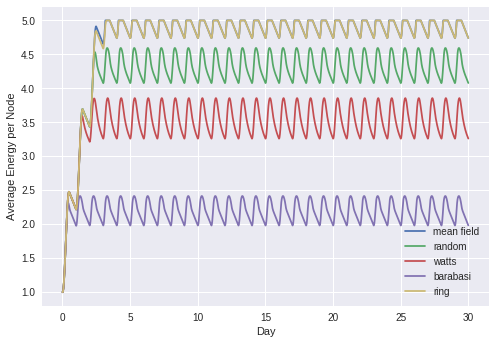

In [4]:


#Average energy in the system
for i  in range(len(graphs)):
    plt.plot(steps, np.mean(local_status[i,:,:], axis=1), label=labels[i])
plt.xlabel('Day')
plt.ylabel('Average Energy per Node')
plt.legend(loc=0)
plt.show()

In [ ]:

fig, axes = plt.subplots(2,2, figsize=(10,10))
for i in range(2):
    for j in range(2):
        sns.heatmap(local_status[i*2+j,:,:].T, 
                    ax=axes[i,j])
plt.ylabel("Node")
plt.xlabel("Step")
plt.show()

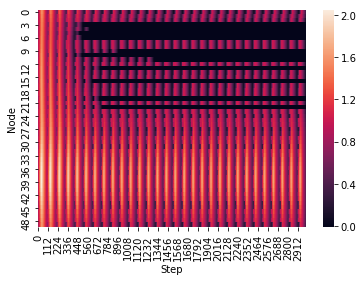

In [52]:
sns.heatmap(local_status[4,:,:].T)
plt.ylabel("Node")
plt.xlabel("Step")
plt.show()

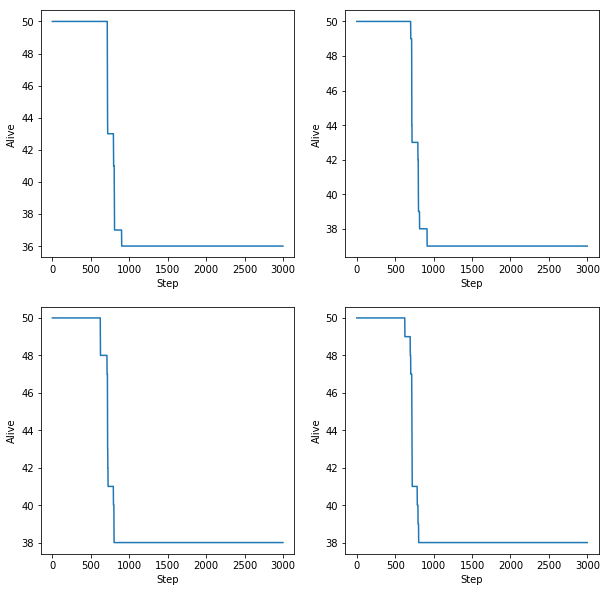

In [53]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
for i in range(2):
    for j in range(2):
        alive = [len(np.nonzero(local_status[i*2+j,t, :])[0]) for t in  range(max_it)]
        axes[i,j].plot(range(max_it), alive)
        axes[i,j].set_ylabel("Alive")
        axes[i,j].set_xlabel("Step")
plt.show()



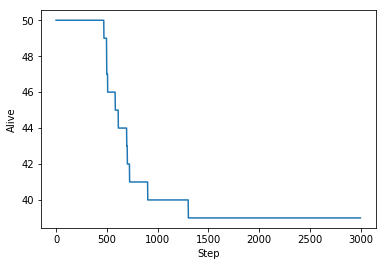

In [54]:
alive = [len(np.nonzero(local_status[4,t, :])[0]) for t in  range(max_it)]
plt.plot(range(max_it), alive)
plt.ylabel("Alive")
plt.xlabel("Step")
plt.show()

